## 모듈 및 데이터 불러오기

In [220]:
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns
import datetime

import tensorflow as tf
import tensorflow.keras as keras
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# pandas 옵션 설정
pd.options.display.max_columns = 80
pd.options.display.precision = 15

# 한글 글꼴 설정
font_name = font_manager.FontProperties(fname="/usr/share/fonts/nhn-nanum/NanumGothic.ttf").get_name()
rc('font', family=font_name)

# 경고메세지 무시
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
cn7 = pd.read_csv('cn7.csv', index_col = 0)
rg3 = pd.read_csv('rg3.csv', index_col = 0)

## 양품 데이터와 불량품 데이터 분리

In [136]:
# CN7과 RG3를 각각 양품과 불량으로 나누고 오토인코더 모델 학습에 사용할 컬럼만 남긴다.
cn_y = cn7[cn7['PassOrFail'] == 0].drop(['TimeStamp', 'PART_FACT_PLAN_DATE', 'PassOrFail'], axis = 1)
cn_n = cn7[cn7['PassOrFail'] == 1].drop(['TimeStamp', 'PART_FACT_PLAN_DATE', 'PassOrFail'], axis = 1)

rg_y = rg3[rg3['PassOrFail'] == 0].drop(['TimeStamp', 'PART_FACT_PLAN_DATE', 'PassOrFail'], axis = 1)
rg_n = rg3[rg3['PassOrFail'] == 1].drop(['TimeStamp', 'PART_FACT_PLAN_DATE', 'PassOrFail'], axis = 1)

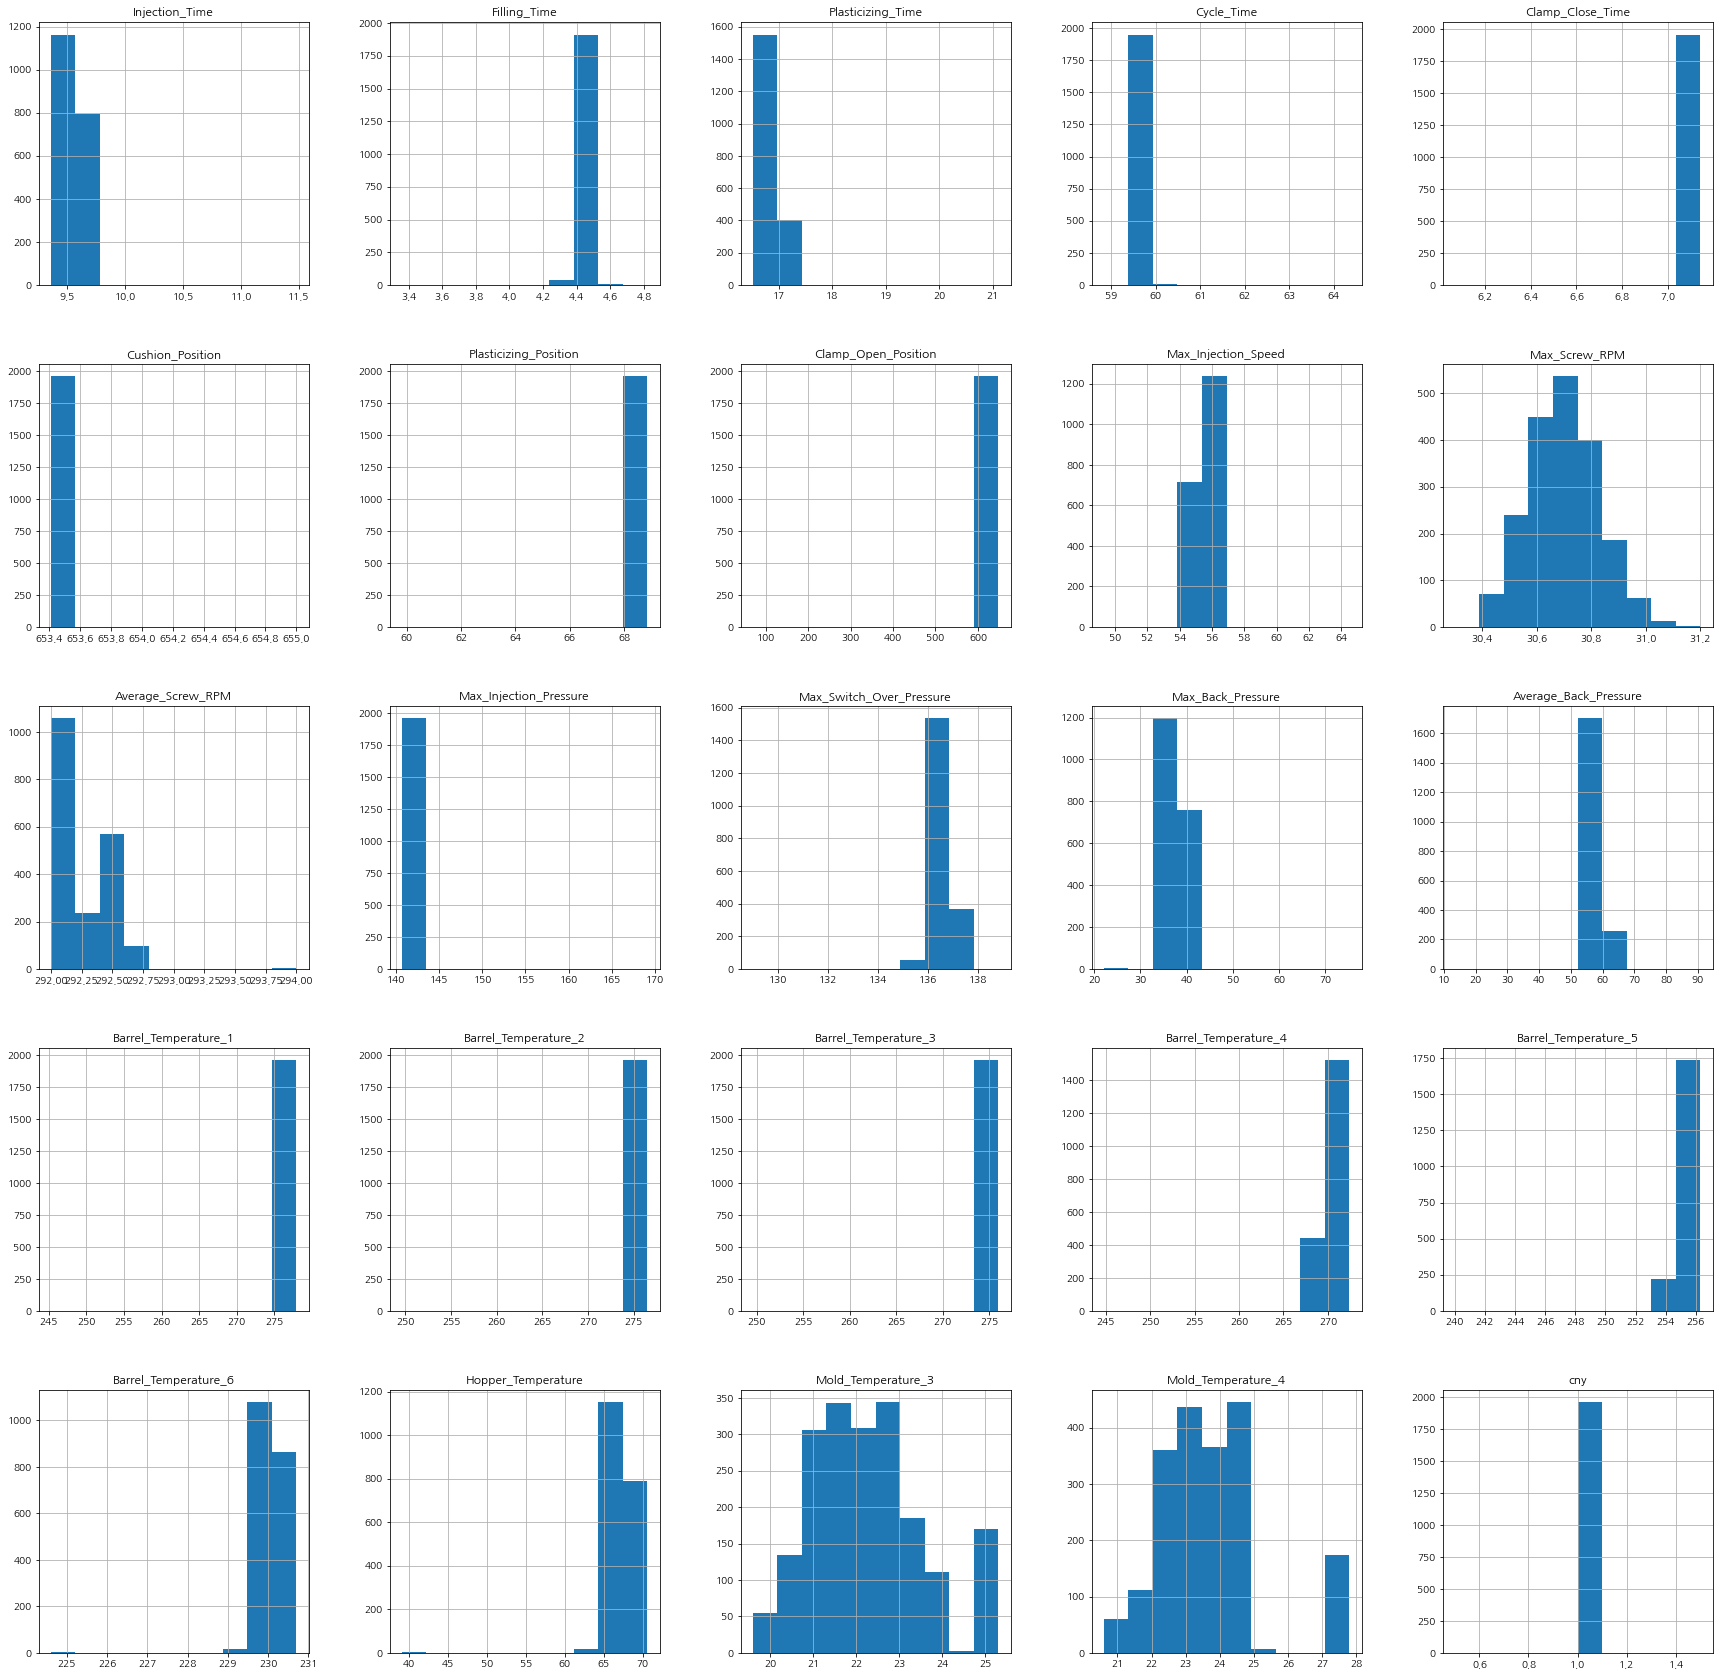

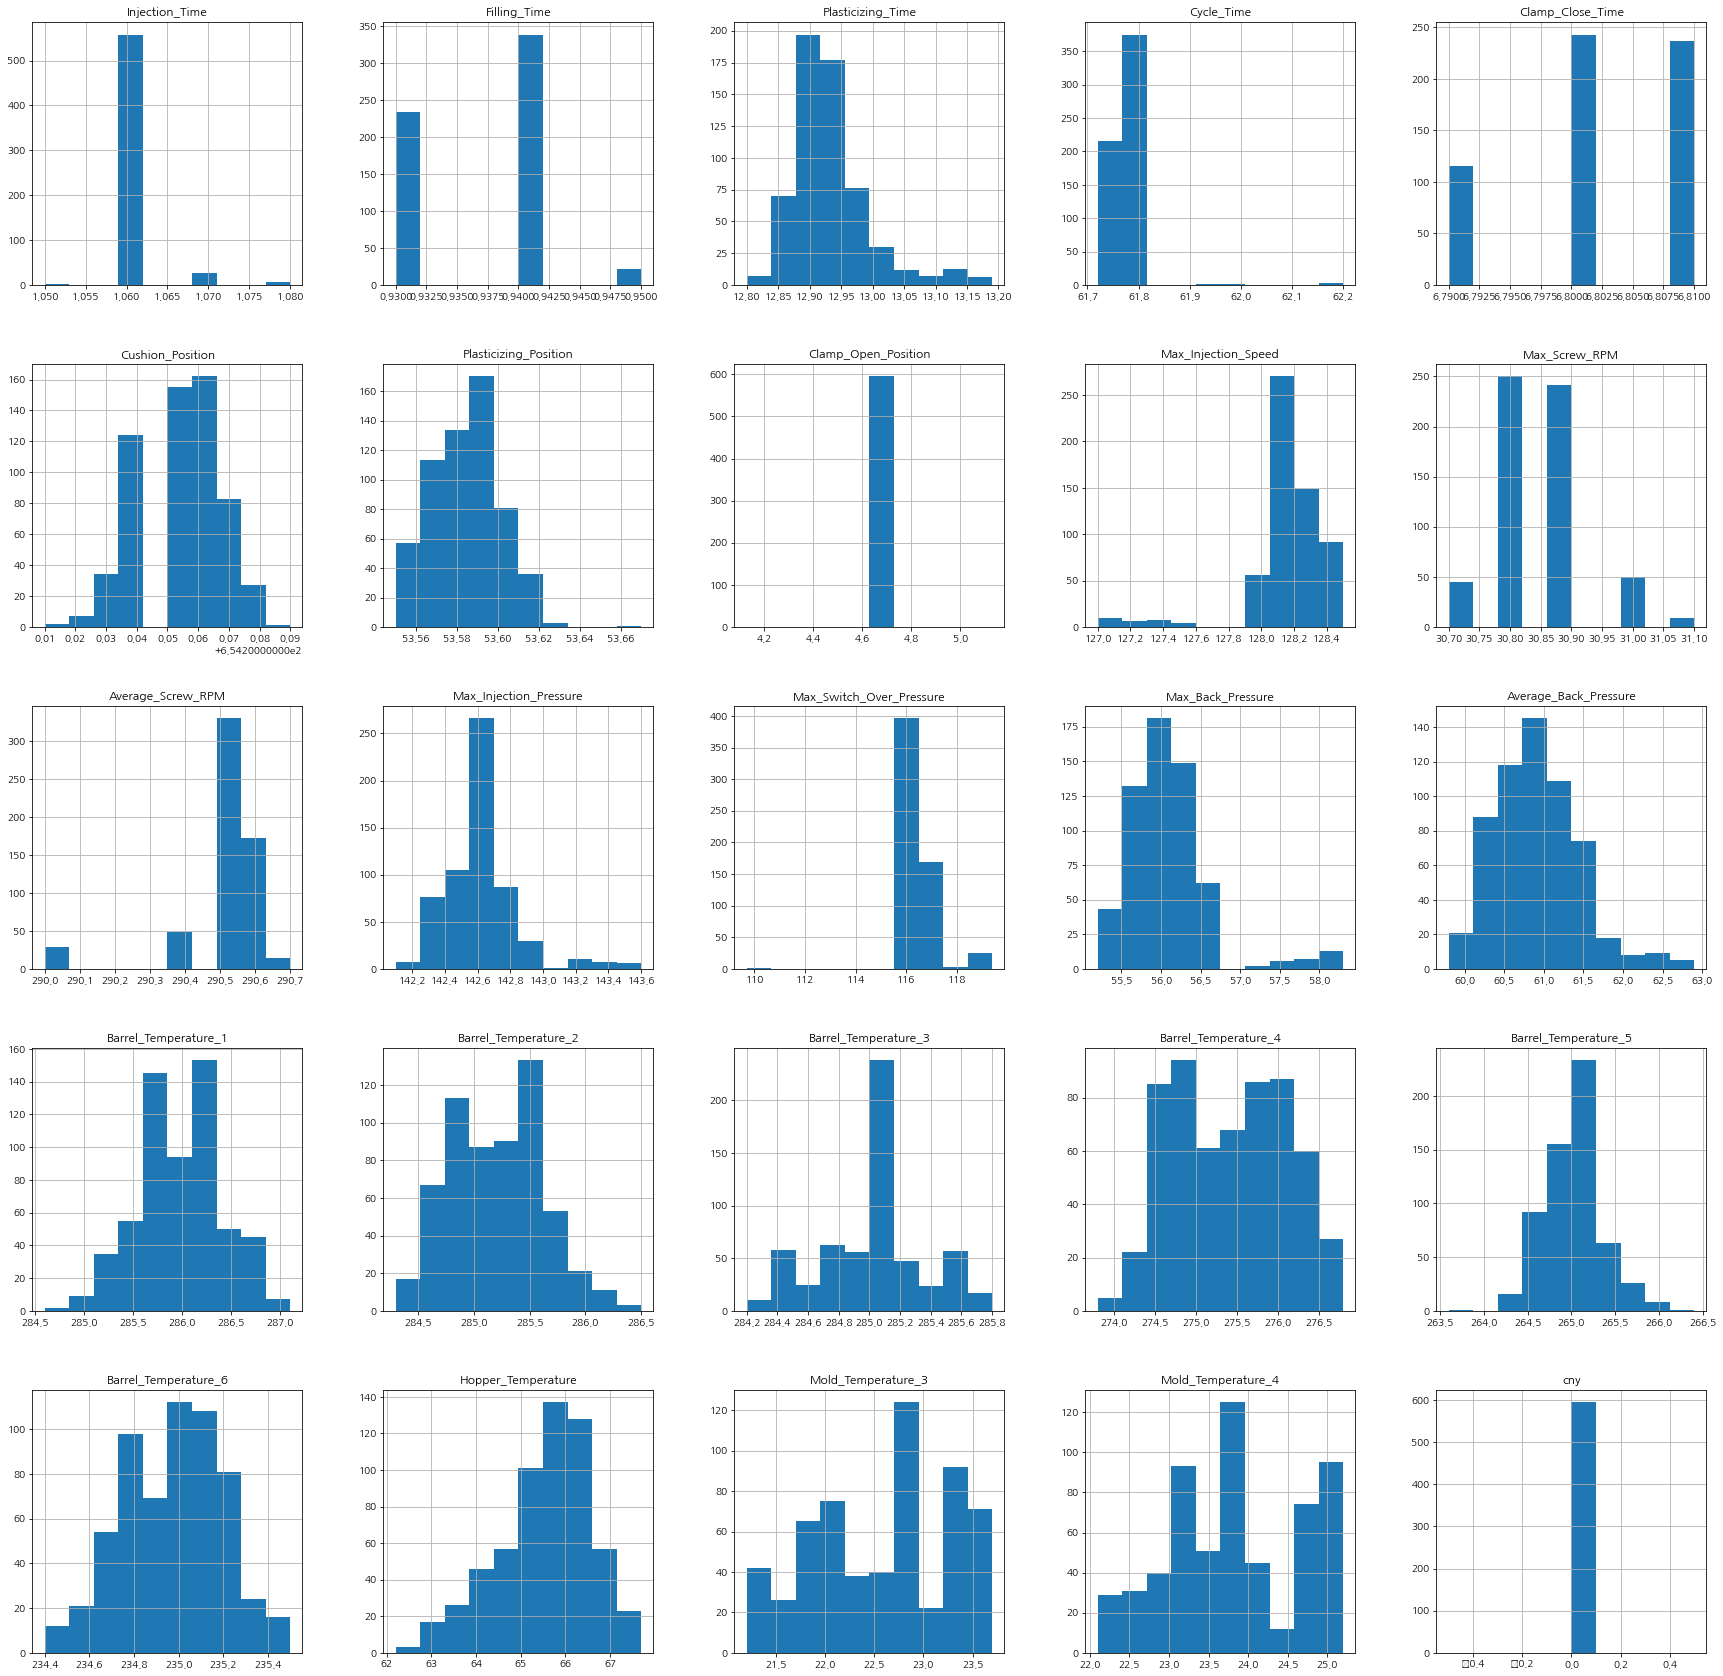

In [240]:
# CN7 제품 중 양품 데이터의 변수별 분포 시각화
cn_y.hist(figsize = (30, 30))
plt.show()

# RG3 제품 중 양품 데이터의 변수별 분포 시각화
rg_y.hist(figsize = (30, 30))
plt.show()

In [137]:
# 오토인코더 학습 시 하나의 모델로 두개의 제품에서 불량을 모두 예측할 수 있도록 한다.
# 두 제품의 데이터를 동시에 학습시키기 위해 제품명을 표시한 컬럼을 생성한다. (CN7: 1, RG3: 0)
cn_y['PART'] = 1
cn_n['PART'] = 1
rg_y['PART'] = 0
rg_n['PART'] = 0

## scaling, train_test_split

In [140]:
# 정규화 함수로 MinMaxScaler 사용
scaler = MinMaxScaler()

# CN7의 양품데이터에 MinMaxScaler 적용 후 순서를 랜덤하게 섞고 9:1의 비율로 훈련, 테스트 데이터를 나눈다.
cn_Y = scaler.fit_transform(cn_y)
np.random.shuffle(cn_Y)
cn_train = cn_Y[:round(len(cn_Y) * .9)]
cn_test = cn_Y[round(len(cn_Y) * .9):]

# RG3의 양품데이터에 MinMaxScaler 적용 후 순서를 랜덤하게 섞고 9:1의 비율로 훈련, 테스트 데이터를 나눈다.
rg_Y = scaler.fit_transform(rg_y)
np.random.shuffle(rg_Y)
rg_train = rg_Y[:round(len(rg_Y) * .9)]
rg_test = rg_Y[round(len(rg_Y) * .9):]

# 불량품 데이터에도 각각 MinMaxScaler를 적용
cn_N = scaler.fit_transform(cn_n)
rg_N = scaler.fit_transform(rg_n)

In [141]:
# CN7과 RG3의 학습 데이터를 합쳐서 통합 학습 데이터로 만든 후 순서를 랜덤하게 섞는다.
train = np.concatenate([cn_train, rg_train])
np.random.shuffle(train)

# 테스트 데이터도 동일하게 합쳐서 통합 테스트 데이터로 만든다.
test = np.concatenate([cn_test, rg_test])

In [241]:
train.shape

(2299, 25)

## training

In [142]:
# 오토인코더 모델 구축

encoder = Sequential()
encoder.add(Dense(16))
encoder.add(LeakyReLU(alpha = 0.1))
encoder.add(Dense(8))
encoder.add(LeakyReLU(alpha = 0.1))

decoder = Sequential()
decoder.add(Dense(16, input_shape = [8]))
decoder.add(LeakyReLU(alpha = 0.1))
decoder.add(Dense(train.shape[1]))
decoder.add(LeakyReLU(alpha = 0.1))

model = Sequential([encoder, decoder])

2021-12-02 15:10:43.219731: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-12-02 15:10:43.277936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-02 15:10:43.279280: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:05.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-12-02 15:10:43.279435: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-02 15:10:43.280661: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:

In [143]:
# 모델 컴파일
model.compile(loss="mse", optimizer=Adam(lr=0.01), metrics=['accuracy'])

# 학습
history = model.fit(train, train, batch_size=16, epochs=100, validation_split = 0.2, callbacks=[EarlyStopping(monitor="val_loss", patience=10, mode="min")], )

Epoch 1/100


2021-12-02 15:10:45.638436: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


115/115 [==============================] - 0s 4ms/step - loss: 0.0342 - accuracy: 0.2713 - val_loss: 0.0101 - val_accuracy: 0.6630
Epoch 2/100
115/115 [==============================] - 0s 2ms/step - loss: 0.0075 - accuracy: 0.5998 - val_loss: 0.0057 - val_accuracy: 0.6848
Epoch 3/100
115/115 [==============================] - 0s 2ms/step - loss: 0.0053 - accuracy: 0.6324 - val_loss: 0.0050 - val_accuracy: 0.6109
Epoch 4/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0046 - accuracy: 0.6302 - val_loss: 0.0041 - val_accuracy: 0.5304
Epoch 5/100
115/115 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 0.6498 - val_loss: 0.0037 - val_accuracy: 0.5326
Epoch 6/100
115/115 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 0.6922 - val_loss: 0.0036 - val_accuracy: 0.5609
Epoch 7/100
115/115 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 0.6906 - val_loss: 0.0033 - val_accuracy: 0.6783
Epoch 8/100

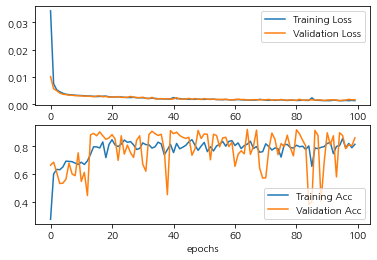

In [144]:
# 학습된 모델의 loss와 accuracy 시각화

plt.subplot(2, 1, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend(loc = 'upper right')

plt.subplot(2, 1, 2)
plt.plot(history.history["accuracy"], label="Training Acc")
plt.plot(history.history["val_accuracy"], label="Validation Acc")
plt.legend(loc = 'lower right')
plt.xlabel('epochs')
plt.savefig('acc_loss.png', dpi=300)
plt.show()

## threshold

In [243]:
# 훈련 데이터의 loss 평균에서 3표준 편차의 범위에 모든 값이 들어간다고 가정하고 임계값 설정

train_pred = model.predict(train)
train_loss = np.mean(np.square(train_pred - train), axis=1)

threshold = np.mean(train_loss)  + 3 * np.std(train_loss)

print("threshold: ", threshold)

threshold:  0.012357105410914799


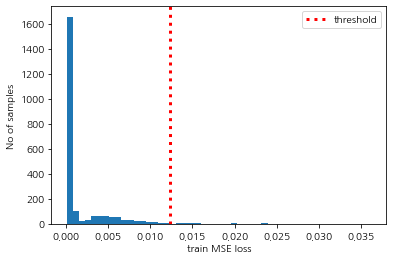

불량 개수:  43


In [245]:
# 훈련 데이터 mse (train data mse)

plt.hist(train_loss, bins=50)
plt.axvline(x=threshold, color='r', linewidth=3, linestyle = ':', label = 'threshold')
plt.xlabel("train MSE loss")
plt.ylabel("No of samples")
plt.legend()
plt.show() 

train_anomalies = train_loss > threshold
print("불량 개수: ", np.sum(train_anomalies)) # number of defects

## cn7 confusion matrix

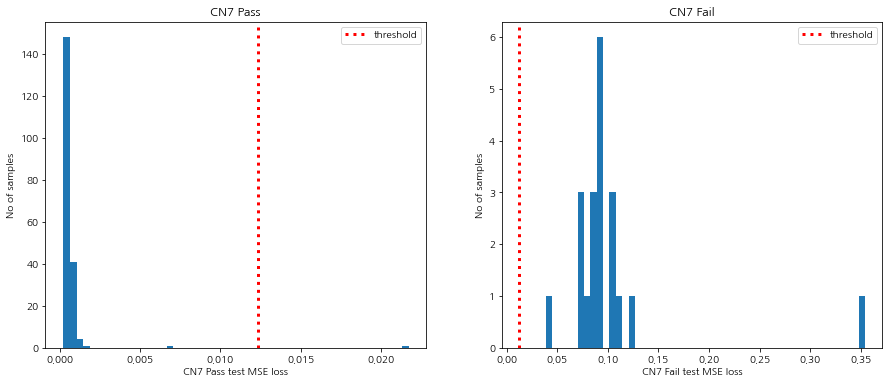

양품 데이터 불량 예측 개수:  1
불량 데이터 불량 예측 개수:  20


In [257]:
# CN7 데이터 mse 시각화

cn_predict_Y = model.predict(cn_test)
cn_Y_mse= np.mean(np.square(cn_predict_Y - cn_test), axis=1)
cn_predict_N = model.predict(cn_N)
cn_N_mse= np.mean(np.square(cn_predict_N - cn_N), axis=1)

fig = plt.figure(figsize=(15, 6)) 
plt.subplot(1, 2, 1)
plt.hist(cn_Y_mse, bins=50)
plt.axvline(x=threshold, color='r', linewidth=3, linestyle = ':', label = 'threshold')
plt.xlabel("CN7 Pass test MSE loss")
plt.ylabel("No of samples")
plt.title('CN7 Pass')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(cn_N_mse, bins=50)
plt.axvline(x=threshold, color='r', linewidth=3, linestyle = ':', label = 'threshold')
plt.xlabel("CN7 Fail test MSE loss")
plt.ylabel("No of samples")
plt.title('CN7 Fail')
plt.legend()
plt.show() 

cn_Y_anomalies = cn_Y_mse > threshold
cn_N_anomalies = cn_N_mse > threshold
print("양품 데이터 불량 예측 개수: ", np.sum(cn_Y_anomalies)) # number of defects
print("불량 데이터 불량 예측 개수: ", np.sum(cn_N_anomalies)) # number of defects

## rg3 confusion matrix

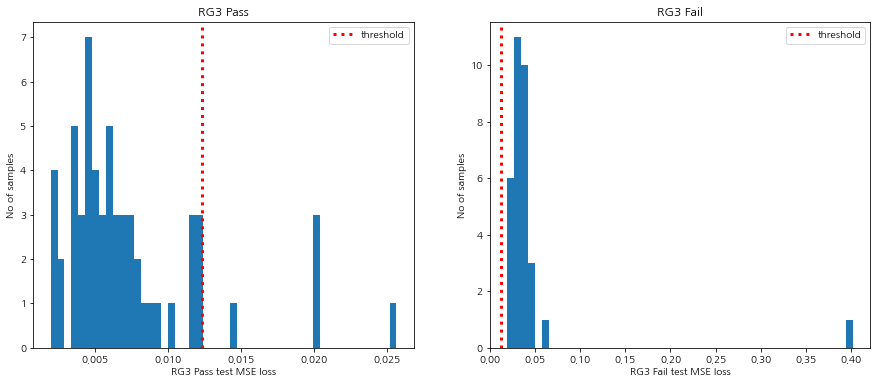

양품 데이터 불량 예측 개수:  5
불량 데이터 불량 예측 개수:  32


In [258]:
# RG3 데이터 mse 시각화

rg_predict_Y = model.predict(rg_test)
rg_Y_mse= np.mean(np.square(rg_predict_Y - rg_test), axis=1)
rg_predict_N = model.predict(rg_N)
rg_N_mse= np.mean(np.square(rg_predict_N - rg_N), axis=1)

fig = plt.figure(figsize=(15, 6)) 
plt.subplot(1, 2, 1)
plt.hist(rg_Y_mse, bins=50)
plt.axvline(x=threshold, color='r', linewidth=3, linestyle = ':', label = 'threshold')
plt.xlabel("RG3 Pass test MSE loss")
plt.ylabel("No of samples")
plt.title('RG3 Pass')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(rg_N_mse, bins=50)
plt.axvline(x=threshold, color='r', linewidth=3, linestyle = ':', label = 'threshold')
plt.xlabel("RG3 Fail test MSE loss")
plt.ylabel("No of samples")
plt.title('RG3 Fail')
plt.legend()
plt.show() 

rg_Y_anomalies = rg_Y_mse > threshold
rg_N_anomalies = rg_N_mse > threshold
print("양품 데이터 불량 예측 개수: ", np.sum(rg_Y_anomalies)) # number of defects
print("불량 데이터 불량 예측 개수: ", np.sum(rg_N_anomalies)) # number of defects

## 성능 지표 결과

In [261]:
cn_true = np.concatenate([np.zeros(len(cn_Y_anomalies)), np.ones(len(cn_N_anomalies))])
cn_prediction = np.concatenate([cn_Y_anomalies, cn_N_anomalies])

rg_true = np.concatenate([np.zeros(len(rg_Y_anomalies)), np.ones(len(rg_N_anomalies))])
rg_prediction = np.concatenate([rg_Y_anomalies, rg_N_anomalies])

print('CN7 confusion matrix')
print(confusion_matrix(cn_true, cn_prediction))
print()
print('RG3 confusion matrix')
print(confusion_matrix(rg_true, rg_prediction))

CN7 confusion matrix
[[195   1]
 [  0  20]]

RG3 confusion matrix
[[54  5]
 [ 0 32]]


In [263]:
print('CN7 성능 지표')
print('Precision:', precision_score(cn_true, cn_prediction))
print("Recall:", recall_score(cn_true, cn_prediction))
print("F1:",f1_score(cn_true, cn_prediction))
print()
print('RG3 성능 지표')
print("Precision:", precision_score(rg_true, rg_prediction))
print("Recall:", recall_score(rg_true, rg_prediction))
print("F1:",f1_score(rg_true, rg_prediction))

CN7 성능 지표
Precision: 0.9523809523809523
Recall: 1.0
F1: 0.975609756097561

RG3 성능 지표
Precision: 0.8648648648648649
Recall: 1.0
F1: 0.927536231884058


## 최적 임계값 확인

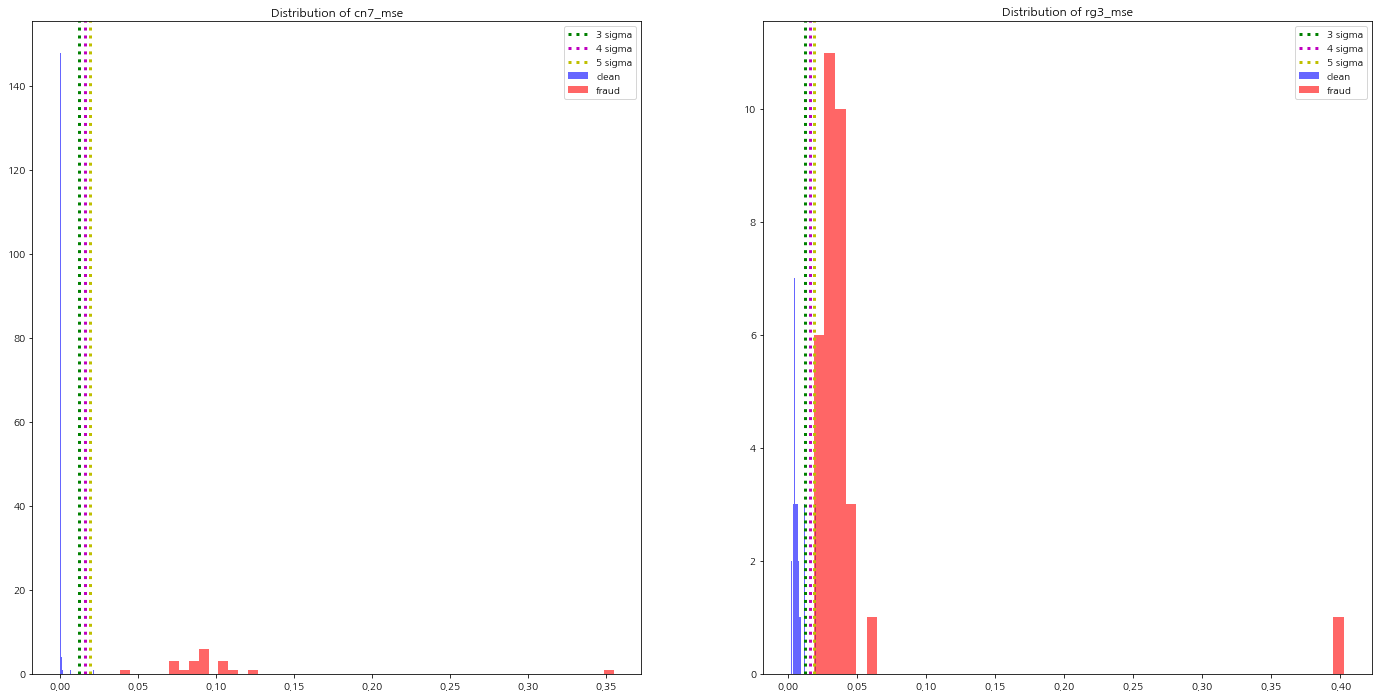

In [159]:
# 임계값 여러개 설정
threshold3 = np.mean(train_loss)  + 3 * np.std(train_loss)
threshold4 = np.mean(train_loss)  + 4 * np.std(train_loss)
threshold5 = np.mean(train_loss)  + 5 * np.std(train_loss)

# 시각화
fig, ax = plt.subplots(1, 2, figsize=(24,12))

ax[0].hist(cn_Y_mse, bins=50, density=False, label="clean", alpha=.6, color="blue")
ax[0].hist(cn_N_mse, bins=50, density=False, label="fraud", alpha=.6, color="red")
ax[0].set_title("Distribution of cn7_mse")
ax[0].axvline(x=threshold3, color='g', linewidth=3, linestyle = ':', label = '3 sigma')
ax[0].axvline(x=threshold4, color='m', linewidth=3, linestyle = ':', label = '4 sigma')
ax[0].axvline(x=threshold5, color='y', linewidth=3, linestyle = ':', label = '5 sigma')
ax[0].legend()

ax[1].hist(rg_Y_mse, bins=50, density=False, label="clean", alpha=.6, color="blue")
ax[1].hist(rg_N_mse, bins=50, density=False, label="fraud", alpha=.6, color="red")
ax[1].set_title("Distribution of rg3_mse")
ax[1].axvline(x=threshold3, color='g', linewidth=3, linestyle = ':', label = '3 sigma')
ax[1].axvline(x=threshold4, color='m', linewidth=3, linestyle = ':', label = '4 sigma')
ax[1].axvline(x=threshold5, color='y', linewidth=3, linestyle = ':', label = '5 sigma')
ax[1].legend()

plt.show()

In [160]:
model.save('autoencoder.h5')